## Notebook Setup

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('Using PyTorch version:', torch.__version__, 'with device:', device)

Using PyTorch version: 2.1.0+cu121 with device: cuda


## Prepare Data

### Define constants that will be used throughout modeling process

In [86]:
num_points = 2000 # define number of total points across the hot plate      num_points = 4000
border_coords = [-1, 1] # define [lower bound, upper bound] of hot plate    border_coords = [-5, 5]
temp_range = [-1, 1] # define [lower bound, upper bound] of temperatures    temp_range = [-2, 2]
epochs = 1000
k = 1
lr = 5e-4

### Create boundary points

Text(0, 0.5, 'Y')

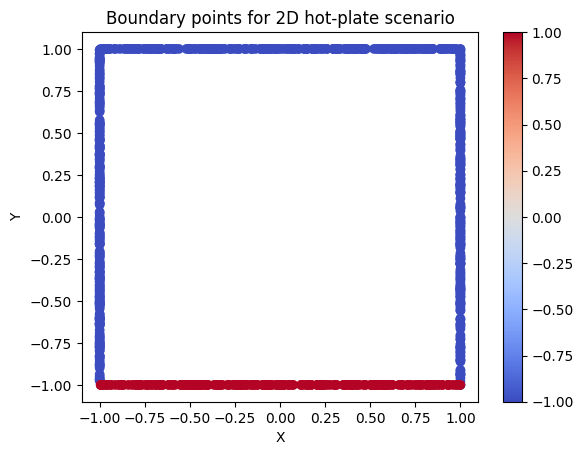

In [87]:
border_x = np.random.choice(border_coords, num_points//4)
dist_y = np.random.uniform(border_coords[0], border_coords[1], num_points//4)

border_y = np.random.choice(border_coords, num_points//4)
dist_x = np.random.uniform(border_coords[0], border_coords[1], num_points//4)

final_lr = np.hstack((border_x, dist_y))
final_tb = np.hstack((dist_x, border_y))

boundary_locs = np.vstack((final_lr, final_tb)).T
boundary_temps = np.where(boundary_locs[:,1] == border_coords[0], temp_range[1], temp_range[0]).reshape(num_points//2, 1)
boundary = np.hstack((boundary_locs, boundary_temps))

plt.scatter(boundary[:,0].T, boundary[:,1].T, c=boundary[:,2].T, cmap="coolwarm")
plt.colorbar()
plt.title("Boundary points for 2D hot-plate scenario")
plt.xlabel("X")
plt.ylabel("Y")

### Create collocation points

Text(0, 0.5, 'Y')

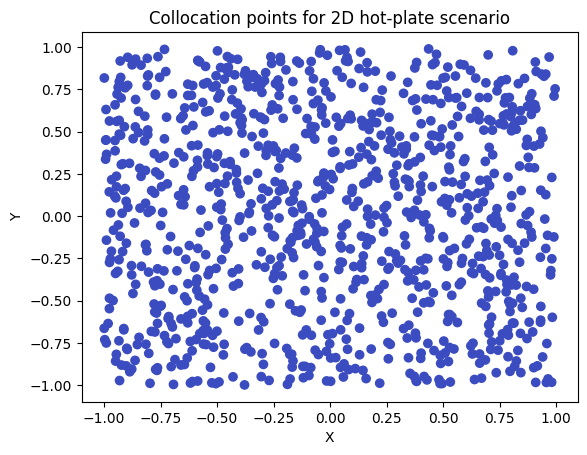

In [88]:
diff_locs = np.random.uniform(border_coords[0], border_coords[1], size=(num_points//2, 2))
diff_temp = np.full((num_points//2, 1), temp_range[0])

collocation = np.hstack((diff_locs, diff_temp))

plt.scatter(collocation[:,0].T, collocation[:,1].T, c=collocation[:,2].T, cmap="coolwarm")
plt.title("Collocation points for 2D hot-plate scenario")
plt.xlabel("X")
plt.ylabel("Y")

### Plot combined boundary and collocation points

Text(0, 0.5, 'Y')

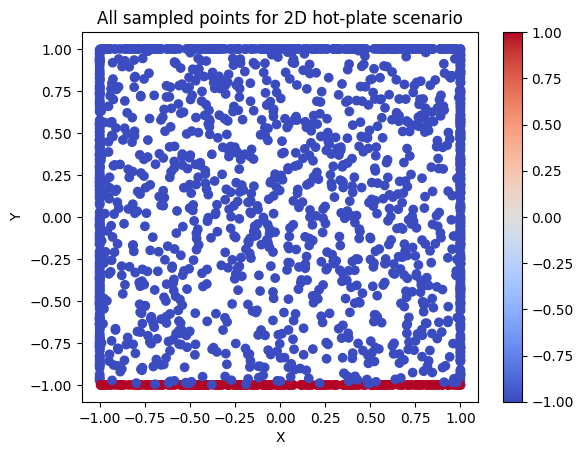

In [89]:
combined = np.vstack((boundary, collocation))

plt.scatter(combined[:,0].T, combined[:,1].T, c=combined[:,2].T, cmap="coolwarm")
plt.colorbar()
plt.title("All sampled points for 2D hot-plate scenario")
plt.xlabel("X")
plt.ylabel("Y")

## Define Model

### Define custom Fourier Upsampling layer

In [34]:
class FourierLayer(nn.Module):
  def __init__(self, size_in, size_out):
    super().__init__()
    self.size_in, self.size_out = size_in, size_out

    w = torch.zeros([size_out, size_in], dtype=torch.float32, device=torch.device('cuda'))
    self.w = nn.Parameter(w)
    wb = torch.zeros([size_out], dtype=torch.float32, device=torch.device('cuda'))
    self.wb = nn.Parameter(wb)

    r = torch.zeros([size_out, size_in], dtype=torch.cfloat, device=torch.device('cuda'))
    self.r = nn.Parameter(r)
    rb = torch.zeros([size_out], dtype=torch.cfloat, device=torch.device('cuda'))
    self.rb = nn.Parameter(rb)

  def forward(self, x):
    fcoeff = torch.fft.fft(x)
    ftransform = torch.matmul(fcoeff, self.r.T) + self.rb
    fmat = torch.fft.ifft(ftransform)

    skip = torch.matmul(x, self.w.T) + self.wb

    return fmat.real + skip

In [56]:
class FPINN2D(nn.Module):
  """
  class for 2-dimensional Fourier-PINN
  """
  def __init__(self, in_dim=2):
    super().__init__()
    self.linear1 = FourierLayer(in_dim, 20)
    self.activation1 = nn.Sigmoid()
    self.linear2 = FourierLayer(20, 20)
    self.activation2 = nn.Sigmoid()
    self.linear3 = FourierLayer(20, 1)


  def forward(self, x, y):
    xy_cat = torch.cat((x, y), axis=1)
    out = self.activation1(self.linear1(xy_cat))
    out = self.activation2(self.linear2(out))
    out = self.linear3(out)
    return out


  def boundary_loss(self, x, x_hat):
    return torch.mean(torch.square(x - x_hat))


  def PDE_loss(self, points_x, points_y, k):
    forward_out = self.forward(points_x, points_y)

    ux = torch.autograd.grad(forward_out, points_x, torch.ones_like(forward_out), create_graph=True)[0]
    uxx = torch.autograd.grad(ux, points_x, torch.ones_like(ux), create_graph=True)[0]

    uy = torch.autograd.grad(forward_out, points_y, torch.ones_like(forward_out), create_graph=True)[0]
    uyy = torch.autograd.grad(uy, points_y, torch.ones_like(uy), create_graph=True)[0]

    return torch.mean(torch.square(uxx + uyy + k**2 * forward_out))


  def train_pinn(self, boundary, collocation, n_epochs=100, lr=5e-4, k=1):
    optimizer = optim.Adam(self.parameters(), lr=lr)
    train_loss_list = []

    boundary_x = boundary[:,0:1].requires_grad_()
    boundary_y = boundary[:,1:2].requires_grad_()
    boundary_temp = boundary[:,2:3].requires_grad_()
    collocation_x = collocation[:,0:1].requires_grad_()
    collocation_y = collocation[:,1:2].requires_grad_()

    for epoch in range(1, n_epochs + 1):
      self.train()
      optimizer.zero_grad()
      train_loss = 0

      temp_hat = self.forward(boundary_x, boundary_y)
      pde_loss = self.PDE_loss(collocation_x, collocation_y, k)
      b_loss = self.boundary_loss(boundary_temp, temp_hat)
      total_loss = pde_loss + b_loss

      total_loss.backward()
      optimizer.step()

      if epoch % 100 == 0 or epoch == n_epochs - 1:
        print(f"{epoch:5}, {total_loss.detach().cpu().item():.3f}")

      train_loss_list.append(total_loss.detach().cpu().item())

    return train_loss_list


## Train and Test the Model

### Heat equation

In [64]:
num_points = 2000 # define number of total points across the hot plate      num_points = 4000
border_coords = [-1, 1] # define [lower bound, upper bound] of hot plate    border_coords = [-5, 5]
temp_range = [-1, 1] # define [lower bound, upper bound] of temperatures    temp_range = [-2, 2]
epochs = 3000
k = 1
lr = 5e-4

In [68]:
pinn = FPINN2D(in_dim=2).to(device)
boundary_torch = torch.from_numpy(boundary).to(torch.float32).to(device)
collocation_torch = torch.from_numpy(collocation).to(torch.float32).to(device)
loss_list = pinn.train_pinn(boundary=boundary_torch, collocation=collocation_torch, n_epochs=epochs, lr=lr, k=k)

  100, 0.833
  200, 0.596
  300, 0.517
  400, 0.397
  500, 0.363
  600, 0.312
  700, 0.264
  800, 0.218
  900, 0.155
 1000, 0.132
 1100, 0.125
 1200, 0.120
 1300, 0.116
 1400, 0.112
 1500, 0.108
 1600, 0.105
 1700, 0.101
 1800, 0.098
 1900, 0.095
 2000, 0.094
 2100, 0.092
 2200, 0.091
 2300, 0.091
 2400, 0.090
 2500, 0.090
 2600, 0.089
 2700, 0.089
 2800, 0.088
 2900, 0.087
 2999, 0.087
 3000, 0.087


Text(0.5, 1.0, 'Validation loss')

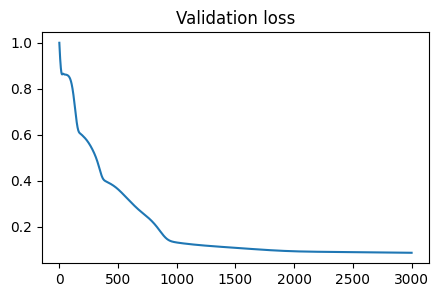

In [69]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), loss_list)
plt.title('Validation loss')

(-1.0101010101010102,
 1.0101010101010097,
 -1.0101010101010102,
 1.0101010101010097)

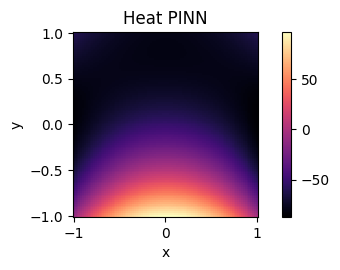

In [70]:
n = 100
X = np.linspace(border_coords[0], border_coords[1], n)
Y = np.linspace(border_coords[0], border_coords[1], n)
X0, Y0 = np.meshgrid(X, Y)
X = X0.reshape([n*n, 1])
Y = Y0.reshape([n*n, 1])
X_T = torch.from_numpy(X).to(torch.float32).to(device)
Y_T = torch.from_numpy(Y).to(torch.float32).to(device)
pinn.eval()
S = pinn.forward(X_T, Y_T)
S = S.detach().cpu().numpy().reshape(n, n)
#
plt.subplot(221)
plt.pcolormesh(X0, Y0, 75.*S, cmap="magma")
plt.colorbar()
plt.xlabel("x")
plt.ylabel("y")
plt.title("Heat PINN")
plt.tight_layout()
plt.axis("square")

### Helmholtz with k=2

In [71]:
num_points = 2000 # define number of total points across the hot plate      num_points = 4000
border_coords = [-1, 1] # define [lower bound, upper bound] of hot plate    border_coords = [-5, 5]
temp_range = [-1, 1] # define [lower bound, upper bound] of temperatures    temp_range = [-2, 2]
epochs = 2000
k = 2
lr = 5e-4

In [72]:
pinn = FPINN2D().to(device)
boundary_torch = torch.from_numpy(boundary).to(torch.float32).to(device)
collocation_torch = torch.from_numpy(collocation).to(torch.float32).to(device)
loss_list = pinn.train_pinn(boundary=boundary_torch, collocation=collocation_torch, n_epochs=epochs, lr=lr, k=k)

  100, 0.953
  200, 0.943
  300, 0.942
  400, 0.938
  500, 0.878
  600, 0.666
  700, 0.570
  800, 0.551
  900, 0.536
 1000, 0.517
 1100, 0.488
 1200, 0.448
 1300, 0.416
 1400, 0.396
 1500, 0.382
 1600, 0.368
 1700, 0.353
 1800, 0.335
 1900, 0.321
 1999, 0.310
 2000, 0.310


Text(0.5, 1.0, 'Validation loss')

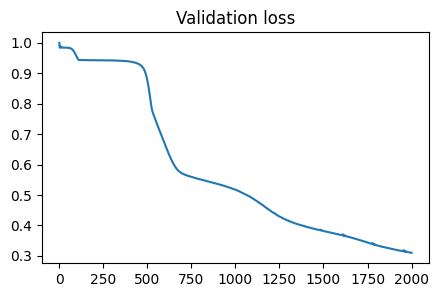

In [73]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), loss_list)
plt.title('Validation loss')

(-1.0101010101010102,
 1.0101010101010097,
 -1.0101010101010102,
 1.0101010101010097)

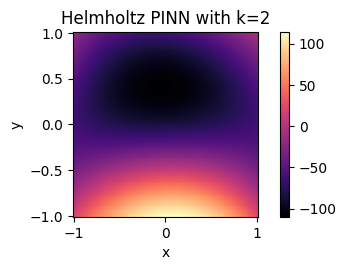

In [74]:
n = 100
X = np.linspace(border_coords[0], border_coords[1], n)
Y = np.linspace(border_coords[0], border_coords[1], n)
X0, Y0 = np.meshgrid(X, Y)
X = X0.reshape([n*n, 1])
Y = Y0.reshape([n*n, 1])
X_T = torch.from_numpy(X).to(torch.float32).to(device)
Y_T = torch.from_numpy(Y).to(torch.float32).to(device)
S = pinn.forward(X_T, Y_T)
S = S.detach().cpu().numpy().reshape(n, n)
#
plt.subplot(221)
plt.pcolormesh(X0, Y0, 75.*S, cmap="magma")
plt.colorbar()
plt.xlabel("x")
plt.ylabel("y")
plt.title("Helmholtz PINN with k=2")
plt.tight_layout()
plt.axis("square")

### Helmholtz with k=2, extended plate

In [82]:
num_points = 8000 # define number of total points across the hot plate      num_points = 4000
border_coords = [-5, 5] # define [lower bound, upper bound] of hot plate    border_coords = [-5, 5]
temp_range = [-3, 3] # define [lower bound, upper bound] of temperatures    temp_range = [-2, 2]
epochs = 3000
k = 2
lr = 5e-4

In [83]:
pinn = FPINN2D(in_dim=2).to(device)
boundary_torch = torch.from_numpy(boundary).to(torch.float32).to(device)
collocation_torch = torch.from_numpy(collocation).to(torch.float32).to(device)
loss_list = pinn.train_pinn(boundary=boundary_torch, collocation=collocation_torch, n_epochs=epochs, lr=lr, k=k)

  100, 8.515
  200, 8.501
  300, 8.385
  400, 8.038
  500, 8.016
  600, 8.003
  700, 7.993
  800, 7.984
  900, 7.970
 1000, 7.945
 1100, 7.905
 1200, 7.752
 1300, 7.415
 1400, 7.063
 1500, 6.679
 1600, 6.647
 1700, 6.631
 1800, 6.617
 1900, 6.605
 2000, 6.593
 2100, 6.581
 2200, 6.570
 2300, 6.560
 2400, 6.547
 2500, 6.533
 2600, 6.516
 2700, 6.495
 2800, 6.466
 2900, 6.429
 2999, 6.379
 3000, 6.378


Text(0.5, 1.0, 'Validation loss')

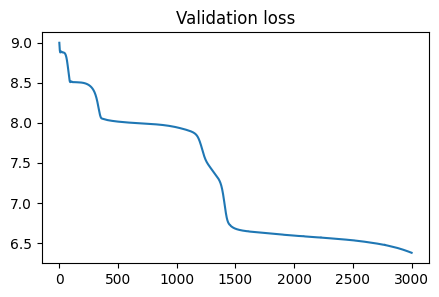

In [84]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), loss_list)
plt.title('Validation loss')

(-5.05050505050505, 5.05050505050505, -5.05050505050505, 5.05050505050505)

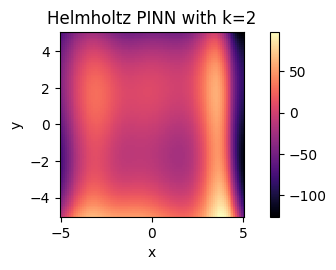

In [85]:
n = 100
X = np.linspace(border_coords[0], border_coords[1], n)
Y = np.linspace(border_coords[0], border_coords[1], n)
X0, Y0 = np.meshgrid(X, Y)
X = X0.reshape([n*n, 1])
Y = Y0.reshape([n*n, 1])
X_T = torch.from_numpy(X).to(torch.float32).to(device)
Y_T = torch.from_numpy(Y).to(torch.float32).to(device)
S = pinn.forward(X_T, Y_T)
S = S.detach().cpu().numpy().reshape(n, n)
#
plt.subplot(221)
plt.pcolormesh(X0, Y0, 75.*S, cmap="magma")
plt.colorbar()
plt.xlabel("x")
plt.ylabel("y")
plt.title("Helmholtz PINN with k=2")
plt.tight_layout()
plt.axis("square")